## Import libraries and python files

In [1]:
#import useful libraries 
import pandas as pd
import json
import sys
import requests
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
import statsmodels.formula.api as smf
%matplotlib inline 

from data_loader import *
%load_ext autoreload
%autoreload 2


##link to the datasets
## https://www.cs.cmu.edu/~ark/personas/
##https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=movies_metadata.csv
##https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset

## Load the different datasets

In [2]:
##load datasets from CMU dataset
df_character = load_character().copy()
df_movie = load_movie().copy()
df_name_cluster = load_name_cluster().copy()
df_summary = load_plot_summary().copy()
df_tropes_cluster = load_tropes_cluster().copy()

In [3]:
df_movie.head()

,Wikipedia ID,Freebase ID,Name,Release date,Box office,Runtime,Languages (Freebase ID:name tuples),Countries (Freebase ID:name tuples),genres (Freebase ID:name tuples),Year,Month,Day
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>


In [4]:
df_movie.shape

(81741, 12)

In [5]:
# Replace 'id-translation.wikidata.json' with the path to your JSON file
file_path = 'id-translation.wikidata.json'

# Load the JSON file into a DataFrame
df_id_translation = pd.read_json(file_path, orient='records', lines=True)

# Display the loaded DataFrame
display(df_id_translation)

,tconst,Freebase ID
0,nm0010930,/m/0282x
1,nm0124133,/m/09b6zr
2,nm0684496,/m/014d3
3,nm0061667,/m/01rgr
4,tt1675434,/m/0hgqwpj
...,...,...
990440,tt20913312,None
990441,tt29623578,None
990442,nm1456284,None
990443,tt27348595,None


In [6]:
df_id_translation = df_id_translation.dropna(subset=['Freebase ID'])
#df_id_translation.drop_duplicates(subset=['Freebase ID'], keep='first', inplace=True)
print(df_id_translation.shape)

(397518, 2)


In [7]:
df_id_translation.drop_duplicates(subset=['Freebase ID'], keep='first', inplace=True)
print(df_id_translation.shape)

(396337, 2)


In [8]:
df_movie = pd.merge(df_movie, df_id_translation, on='Freebase ID', how='left')
display(df_movie)

,Wikipedia ID,Freebase ID,Name,Release date,Box office,Runtime,Languages (Freebase ID:name tuples),Countries (Freebase ID:name tuples),genres (Freebase ID:name tuples),Year,Month,Day,tconst
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24,tt0228333
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,tt0245916
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>,tt0094806
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>,tt0094320
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>,tt0083949
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,3,19,tt1816585
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,1,21,tt1606259
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972,9,22,tt0362411
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,5,21,tt0113726


In [9]:
#compute percentage of missing values for df_mvoei
percentage_missing_values_year = (df_movie['Year'].isna().sum()/len(df_movie['Year']))*100
print(f"The percentage of missing values 'Year' release date is {format(percentage_missing_values_year, '.3f')}%.")

percentage_missing_values_month = (df_movie['Month'].isna().sum()/len(df_movie['Month']))*100
print(f"The percentage of missing values 'Month' release date (and therefore 'Day') is {format(percentage_missing_values_month, '.3f')}%.")

percentage_missing_values_revenues = (df_movie['Box office'].isna().sum()/len(df_movie['Box office']))*100
print(f"The percentage of missing values 'Box office' is {format(percentage_missing_values_revenues, '.3f')}%.")

percentage_missing_values_runtime = (df_movie['Runtime'].isna().sum()/len(df_movie['Runtime']))*100
print(f"The percentage of missing values 'Runtime' is {format(percentage_missing_values_runtime, '.3f')}%.")

percentage_missing_values_tconst = (df_movie['tconst'].isna().sum()/len(df_movie['tconst']))*100
print(f"The percentage of missing values 'tconst' is {format(percentage_missing_values_tconst, '.3f')}%.")


The percentage of missing values 'Year' release date is 8.444%.
The percentage of missing values 'Month' release date (and therefore 'Day') is 51.832%.
The percentage of missing values 'Box office' is 89.722%.
The percentage of missing values 'Runtime' is 25.018%.
The percentage of missing values 'tconst' is 9.769%.


In [10]:
##As we can see, a lot of 'Box office' data is missing

## Load addtionnal datasets and merge what we need 

In [11]:
#load imdb dataset (from kaggle)
df_imdb_movie = load_movie_imdb_kaggle()
df_imdb_rating = load_rating_imdb_kaggle() 

In [12]:
#merge movies with rating 
df_movie_rating = pd.merge(df_imdb_movie, df_imdb_rating, on='tconst', how='inner')
display(df_movie_rating)

,tconst,titleType,Name,originalTitle,isAdult,Year,endYear,Runtime,genres,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45.0,Romance,5.3,207
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100.0,"Documentary,News,Sport",5.3,484
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100.0,\N,4.1,15
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70.0,"Action,Adventure,Biography",6.0,854
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90.0,Drama,5.0,21
...,...,...,...,...,...,...,...,...,...,...,...
299375,tt9916270,movie,Il talento del calabrone,Il talento del calabrone,0,2020,\N,84.0,Thriller,5.8,1446
299376,tt9916362,movie,Coven,Akelarre,0,2020,\N,92.0,"Drama,History",6.4,5600
299377,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019,\N,NaN,"Adventure,History,War",3.5,17
299378,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019,\N,123.0,Drama,8.6,7


In [13]:
#merge CMU dataset with IMDB dataset
df_movie = pd.merge(df_movie, df_movie_rating[['tconst', 'averageRating', 'numVotes']], on=['tconst'], how='left')
display(df_movie)

,Wikipedia ID,Freebase ID,Name,Release date,Box office,Runtime,Languages (Freebase ID:name tuples),Countries (Freebase ID:name tuples),genres (Freebase ID:name tuples),Year,Month,Day,tconst,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24,tt0228333,4.9,56854.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,tt0245916,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>,tt0094806,5.6,40.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>,tt0094320,6.1,2888.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>,tt0083949,6.0,621.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,3,19,tt1816585,NaN,NaN
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,1,21,tt1606259,6.8,3191.0
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972,9,22,tt0362411,5.8,110.0
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,5,21,tt0113726,NaN,NaN


In [14]:
percentage_missing_values_rating = (df_movie['averageRating'].isna().sum()/len(df_movie['averageRating']))*100
print(f"The percentage of missing values 'averageRating' is {format(percentage_missing_values_rating, '.3f')}%.")

percentage_missing_values_votes = (df_movie['numVotes'].isna().sum()/len(df_movie['numVotes']))*100
print(f"The percentage of missing values 'numVotes' is {format(percentage_missing_values_votes, '.3f')}%.")

print(f"The number of movies with missing values for 'averageRating' and 'numVotes' is {df_movie['averageRating'].isna().sum()}.")

The percentage of missing values 'averageRating' is 31.271%.
The percentage of missing values 'numVotes' is 31.271%.
The number of movies with missing values for 'averageRating' and 'numVotes' is 25561.


In [15]:
## load kaggle movie metadata
df_kaggle_movie = load_movie_kaggle()
display(df_kaggle_movie)

,adult,belongs_to_collection,budget,genres,homepage,movieId,tconst,original_language,original_title,overview,...,spoken_languages,status,tagline,Name,video,vote_average,vote_count,Year,Month,Day
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995,10,30
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,12,15
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,12,22
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,12,22
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,<NA>,<NA>,<NA>
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0,2011,11,17
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003,8,1
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,[],Released,NaN,Satan Triumphant,False,0.0,0.0,1917,10,21


In [16]:
#merge the datasets on the 'Name' column
#df_movie = df_movie.merge(df_kaggle_movie[['Name', 'Year', 'Month', 'Day']], on=['Name', 'Year'], how='left', suffixes=('', '_df2'))
df_movie = df_movie.merge(df_kaggle_movie[['Name', 'Year', 'tconst', 'Month', 'Day']], on=['Name', 'Year','tconst'], how='left', suffixes=('', '_df2'))

In [17]:
#use 'combine_first' to fill in the 'Box office' values from df_kaggle_movie where they are NaN in df_movie
df_movie['Month'] = df_movie['Month'].combine_first(df_movie['Month_df2'])
df_movie['Day'] = df_movie['Day'].combine_first(df_movie['Day_df2'])

#drop the extra 'Box office' column from df_kaggle_movie
df_movie.drop('Month_df2', axis=1, inplace=True)
df_movie.drop('Day_df2', axis=1, inplace=True)
display(df_movie)

,Wikipedia ID,Freebase ID,Name,Release date,Box office,Runtime,Languages (Freebase ID:name tuples),Countries (Freebase ID:name tuples),genres (Freebase ID:name tuples),Year,Month,Day,tconst,averageRating,numVotes
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24,tt0228333,4.9,56854.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,tt0245916,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>,tt0094806,5.6,40.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>,tt0094320,6.1,2888.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>,tt0083949,6.0,621.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81752,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,3,19,tt1816585,NaN,NaN
81753,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,1,21,tt1606259,6.8,3191.0
81754,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972,9,22,tt0362411,5.8,110.0
81755,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,5,21,tt0113726,NaN,NaN


In [18]:
percentage_missing_values_year = (df_movie['Year'].isna().sum()/len(df_movie['Year']))*100
print(f"The percentage of missing values 'Year' release date is {format(percentage_missing_values_year, '.3f')}%.")

percentage_missing_values_month = (df_movie['Month'].isna().sum()/len(df_movie['Month']))*100
print(f"The percentage of missing values 'Month' release date (and therefore 'Day') is {format(percentage_missing_values_month, '.3f')}%.")

#as we can see, we decrease the percentage of missing values for 'Month' and 'Day' by merging the two datasets by almost 10%

The percentage of missing values 'Year' release date is 8.442%.
The percentage of missing values 'Month' release date (and therefore 'Day') is 42.891%.


In [19]:
#load oscar reward dataset
df_oscar = load_oscar_winner()
display(df_oscar)

,Year,year_ceremony,ceremony,category,name,Name,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10755,2022,2023,95,WRITING (Original Screenplay),Written by Daniel Kwan & Daniel Scheinert,Everything Everywhere All at Once,True
10756,2022,2023,95,WRITING (Original Screenplay),Written by Steven Spielberg & Tony Kushner,The Fabelmans,False
10757,2022,2023,95,WRITING (Original Screenplay),Written by Todd Field,Tár,False
10758,2022,2023,95,WRITING (Original Screenplay),Written by Ruben Östlund,Triangle of Sadness,False


In [20]:
#filter the dataframe to only include rows where 'winner' is True
df_winner_movie = df_oscar[df_oscar['winner'] == True]
display(df_winner_movie)

,Year,year_ceremony,ceremony,category,name,Name,winner
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
6,1927,1928,1,ART DIRECTION,William Cameron Menzies,The Dove;,True
9,1927,1928,1,CINEMATOGRAPHY,Charles Rosher,Sunrise,True
10,1927,1928,1,CINEMATOGRAPHY,Karl Struss,Sunrise,True
...,...,...,...,...,...,...,...
10743,2022,2023,95,SOUND,"Mark Weingarten, James H. Mather, Al Nelson, C...",Top Gun: Maverick,True
10745,2022,2023,95,VISUAL EFFECTS,"Joe Letteri, Richard Baneham, Eric Saindon and...",Avatar: The Way of Water,True
10753,2022,2023,95,WRITING (Adapted Screenplay),Screenplay by Sarah Polley,Women Talking,True
10755,2022,2023,95,WRITING (Original Screenplay),Written by Daniel Kwan & Daniel Scheinert,Everything Everywhere All at Once,True


In [21]:
#filter the dataframe to only include rows where 'winner' is True
df_winner_movie = df_oscar[df_oscar['winner'] == True]

In [22]:
df_winner_movie = df_winner_movie.groupby('Name').agg(
    num_oscars_won=pd.NamedAgg(column='winner', aggfunc='size'),
    years_won=pd.NamedAgg(column='year_ceremony', aggfunc=lambda x: list(x))
).reset_index()

display(df_winner_movie)

,Name,num_oscars_won,years_won
0,'Round Midnight,1,[1987]
1,12 Years a Slave,3,"[2014, 2014, 2014]"
2,1917,3,"[2020, 2020, 2020]"
3,20 Feet from Stardom,1,[2014]
4,"20,000 Leagues under the Sea",2,"[1955, 1955]"
...,...,...,...
1310,Zero Dark Thirty,1,[2013]
1311,Zootopia,1,[2017]
1312,Zorba the Greek,3,"[1965, 1965, 1965]"
1313,the accountant,1,[2002]


In [23]:
#filter the dataframe to only include rows where 'winner' is True
df_winner_movie = df_oscar[df_oscar['winner'] == True]

#group by the movie name and count the winners time
df_winner_movie = df_winner_movie.groupby('Name').agg(
    num_oscars_won=pd.NamedAgg(column='winner', aggfunc='size'),
    years_won=pd.NamedAgg(column='year_ceremony', aggfunc=lambda x: list(x))
).reset_index()

#sort the movies by oscars won
df_oscar_wins = df_winner_movie.sort_values(by='num_oscars_won', ascending=False)

display(df_oscar_wins)


,Name,num_oscars_won,years_won
1203,Titanic,12,"[1954, 1998, 1998, 1998, 1998, 1998, 1998, 199..."
1261,West Side Story,11,"[1962, 1962, 1962, 1962, 1962, 1962, 1962, 196..."
1045,The Lord of the Rings: The Return of the King,11,"[2004, 2004, 2004, 2004, 2004, 2004, 2004, 200..."
130,Ben-Hur,11,"[1960, 1960, 1960, 1960, 1960, 1960, 1960, 196..."
376,Gigi,9,"[1959, 1959, 1959, 1959, 1959, 1959, 1959, 195..."
...,...,...,...
516,Kolya,1,[1997]
517,Kon-Tiki,1,[1952]
518,Krakatoa,1,[1933]
521,La Cucaracha,1,[1935]


In [24]:
#merge CUM and oscars awards dataset
df_movie = pd.merge(df_movie, df_oscar_wins, left_on='Name', right_on='Name', how='left')

#replace NaN values in 'num_oscars_won' with 0 for movies that didn't win any Oscars
df_movie['num_oscars_won'].fillna(0, inplace=True)

display(df_movie)

,Wikipedia ID,Freebase ID,Name,Release date,Box office,Runtime,Languages (Freebase ID:name tuples),Countries (Freebase ID:name tuples),genres (Freebase ID:name tuples),Year,Month,Day,tconst,averageRating,numVotes,num_oscars_won,years_won
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,8,24,tt0228333,4.9,56854.0,0.0,NaN
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,2,16,tt0245916,NaN,NaN,0.0,NaN
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,<NA>,<NA>,tt0094806,5.6,40.0,0.0,NaN
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,<NA>,<NA>,tt0094320,6.1,2888.0,0.0,NaN
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,<NA>,<NA>,tt0083949,6.0,621.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81752,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011,3,19,tt1816585,NaN,NaN,0.0,NaN
81753,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011,1,21,tt1606259,6.8,3191.0,0.0,NaN
81754,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972,9,22,tt0362411,5.8,110.0,0.0,NaN
81755,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992,5,21,tt0113726,NaN,NaN,0.0,NaN


In [25]:
percentage_oascar_movies = ((df_movie['num_oscars_won']!=0).sum()/len(df_movie['num_oscars_won']))*100
print(f"The percentage of movies having won an oscar is {format(percentage_oascar_movies, '.3f')}%.")

The percentage of movies having won an oscar is 1.896%.


## Research on release month and revenues 

In [26]:
#first drop nan month release date values 
df_movie_boxoffice = df_movie.copy(deep=True)
df_movie_boxoffice.dropna(subset=['Box office', 'Month'],inplace=True)
#display(df_movie_boxoffice)

In [27]:
movie_revenues = df_movie_boxoffice['Box office'].values
month_release = pd.get_dummies(df_movie_boxoffice['Month']).values
#remove one month column to select it as a baseline here january
month_release = month_release[:, :-1].astype(int)
month_release = sm.add_constant(month_release)

#print(movie_revenues)
#print(month_release)

In [28]:
#model = sm.OLS(movie_revenues, month_release).fit()
#model.summary()

In [29]:
import scipy
import seaborn as sbn
import matplotlib.pyplot as plt
import json
from matplotlib.colors import LogNorm, Normalize



In [30]:
def count_var(df, var, show_graph=True, show_chisquare=True):
    
    df_temp = df.copy(deep=True)
    df_temp.dropna(subset=[var],inplace=True)

    var_values = df_temp.groupby(var).count()['Name'].values
    df_var = list(df_temp.groupby(var).groups.keys())
  
    if show_chisquare:
        print(f'Chisquare statistic : {scipy.stats.chisquare(var_values)}')
    if show_graph:
        order=None
        if var == 'Month':
            order = np.linspace(1,12,12).astype(int)
        if var == 'Weekday Name':
            order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        if var == 'Day':
            order = np.linspace(1,31,31).astype(int)
        sbn.set(rc={'figure.figsize':(10,4)})
        sbn.barplot(x=df_var, y=var_values, order=order)
        plt.title(f'Number of movie premieres for category : {var}')
        plt.xlabel(f'{var}')
        plt.ylabel('Number of movies')
        plt.show()
    
    return var_values


def avg_var(df, var='Box office', group='Month', show_graph=True):
    
    df_temp = df.copy(deep=True)
    df_temp.dropna(subset=[group, var],inplace=True)
    
    df_mean = df_temp.groupby(group).mean()[var].values
    df_var = list(df_temp.groupby(group).groups.keys())

    # Graph
    
    if show_graph:
        sbn.set(rc={'figure.figsize':(10,4)})
        order=None
        if group == 'Month':
            order = np.linspace(1,12,12).astype(int)
        if group == 'Weekday Name':
            order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        if group == 'Day':
            order = np.linspace(1,31,31).astype(int)
        sbn.barplot(x=df_var, y=df_mean, order = order)
        plt.title(f'{var} for movies released for category {group}')
        plt.xlabel('Day of the month')
        plt.ylabel(f'Average {var}')
        plt.show()
    
    return df_mean


In [31]:
def get_weekday(x):
    return pd.to_datetime(x, errors = 'coerce').dayofweek

def get_weekday_name(x):
    return pd.to_datetime(x, errors = 'coerce')

df_time_stamps = df_movie.copy(deep=True)

df_time_stamps.dropna(subset=['Month'], inplace=True)
temp = (df_time_stamps['Year'].astype(str) + '-' 
                                             + df_time_stamps['Month'].astype(str) + '-' 
                                             + df_time_stamps['Day'].astype(str))


df_time_stamps['Weekday'] = temp.apply(get_weekday)
df_time_stamps.dropna(subset=['Weekday'], inplace=True)
df_time_stamps['Weekday'] = df_time_stamps['Weekday'].apply(int)


df_time_stamps['Weekday Name'] = temp.apply(get_weekday_name).dt.day_name()
display(df_time_stamps['Weekday Name'].head())
display(df_time_stamps['Weekday'].head())

0        Friday
1     Wednesday
5      Thursday
7       Tuesday
12       Friday
Name: Weekday Name, dtype: object

0     4
1     2
5     3
7     1
12    4
Name: Weekday, dtype: int64

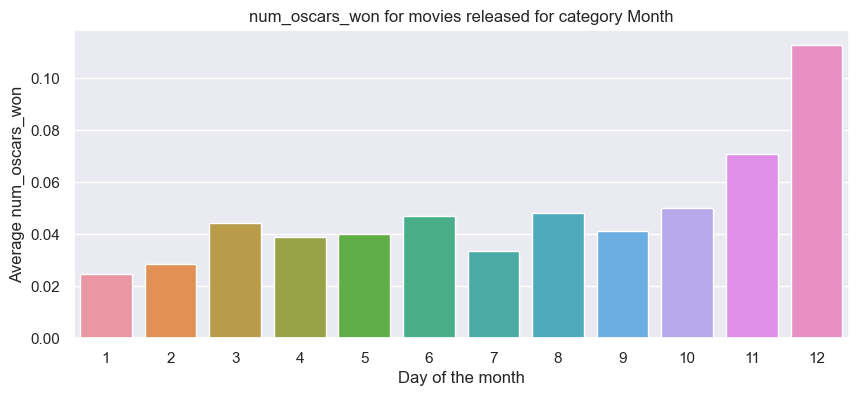

array([0.02488524, 0.02838557, 0.04439802, 0.0387908 , 0.04016166,
       0.04714715, 0.03370419, 0.04817008, 0.04140658, 0.05007587,
       0.07078274, 0.11291461])

In [32]:
#count_var(df_movie, 'Day')
#count_var(df_time_stamps, 'Weekday Name')
#count_var(df_time_stamps, 'Day')
#count_var(df_time_stamps, 'Day')
avg_var(df_time_stamps, 'num_oscars_won', 'Month')

In [33]:
# How many movies of each genre ? 


In [34]:
df_genre_list = df_time_stamps.copy(deep=True)

def get_genres(df):
    genres = dict()
    for i, element in enumerate(df['genres (Freebase ID:name tuples)']):
        t = json.loads(element)
        for v in t.items():
            if v[1] not in genres:
                genres[v[1]] = 0
                #print(genres)
            genres[v[1]] = genres[v[1]] + 1
    return genres

genres = get_genres(df_genre_list)
#genres = sorted(genres)
#print(genres)
#print(len(genres))

In [35]:
def get_movies_genre(df, genre):
    df_temp = df.copy(deep=True)
    df_temp = df_temp[df_temp['genres (Freebase ID:name tuples)'].str.contains(genre)==True] 
    return df_temp

def get_movies_country(df, country):
    df_temp = df.copy(deep=True)
    df_temp = df_temp[df_temp['Countries (Freebase ID:name tuples)'].str.contains(country)==False]
    return df_temp

In [36]:
sorted_genres = sorted(genres.items(), key=lambda x:x[1], reverse=True)
df_movie_genre = df_time_stamps.copy(deep=True)
df_movie_genre.dropna(subset=['Box office'], inplace=True)

n_genre = 20

list_genres = list(dict(sorted_genres).keys())[0:n_genre]

for i in range(10):
    boxoffice_mean = df_movie_genre[df_movie_genre['genres (Freebase ID:name tuples)']
                       .str.contains(sorted_genres[i][0])==True]['Box office'].mean()
    print(f'Average box office for {sorted_genres[i][0]} : {int(boxoffice_mean):,}, which represents {sorted_genres[i][1]:,} movies')


Average box office for Drama : 41,711,679, which represents 21,189 movies
Average box office for Comedy : 52,215,997, which represents 11,330 movies
Average box office for Romance Film : 45,809,834, which represents 7,024 movies
Average box office for Black-and-white : 6,236,742, which represents 6,544 movies
Average box office for Thriller : 71,745,214, which represents 6,238 movies
Average box office for Action : 89,187,861, which represents 5,777 movies
Average box office for Indie : 14,393,350, which represents 4,975 movies
Average box office for Crime Fiction : 51,635,503, which represents 4,719 movies
Average box office for World cinema : 20,251,801, which represents 4,489 movies
Average box office for Short Film : 31,881,762, which represents 4,429 movies


In [37]:
df_genre_list = []
for i in range(n_genre): # todo replace df_movie_genre with df_time_stamps
    temp_df = df_time_stamps[df_time_stamps['genres (Freebase ID:name tuples)']
                             .str.contains(sorted_genres[i][0])==True].copy(deep=True)
    temp_df['Genre'] = sorted_genres[i][0]
    df_genre_list.append(temp_df)

df_movie_genre = pd.concat(df_genre_list)

df_movie_genre.dropna(subset=['Genre'], inplace=True)


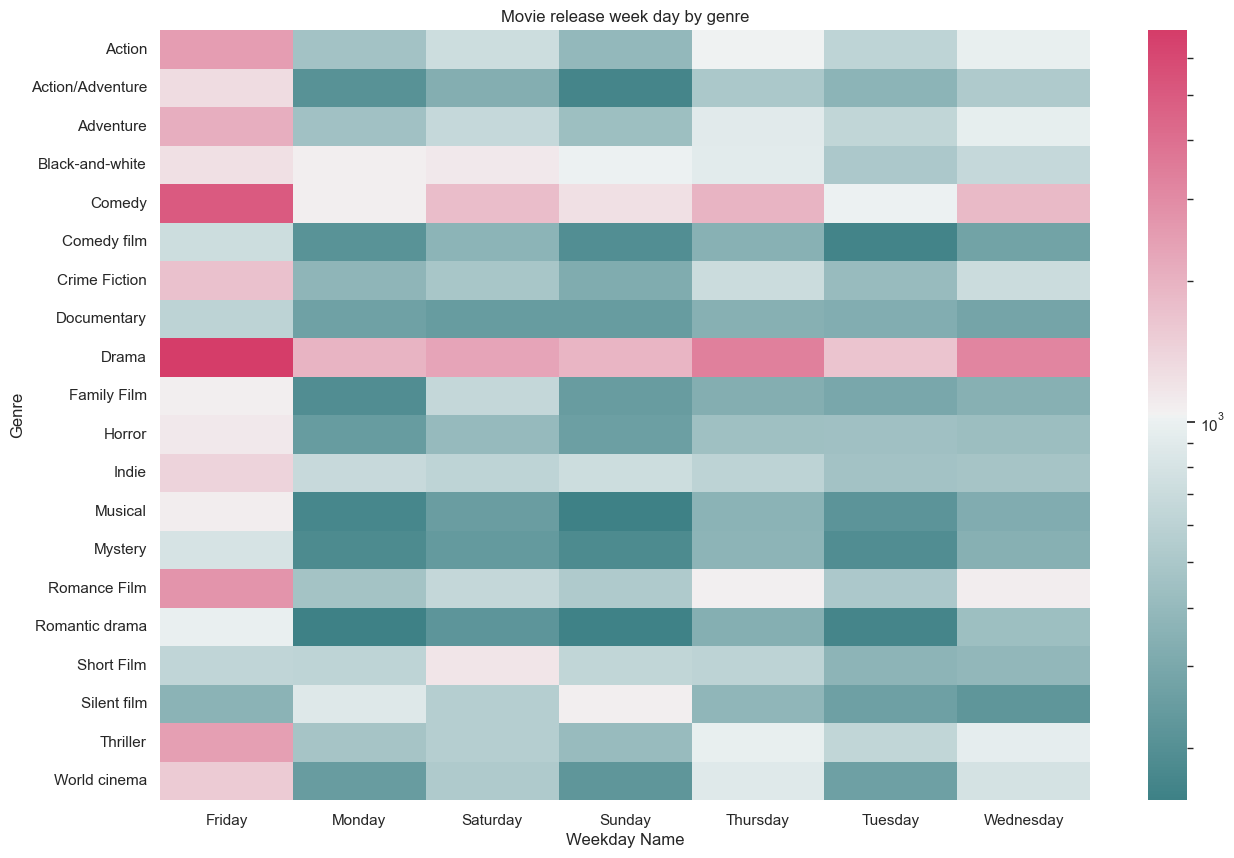

In [38]:
df_genre_weekday = pd.crosstab(df_movie_genre['Genre'],df_movie_genre['Weekday Name'])
plt.subplots(figsize=(15, 10))
sbn.heatmap(df_genre_weekday, annot=False, cmap=sbn.diverging_palette(200, 0, as_cmap=True), norm=LogNorm())
plt.title('Movie release week day by genre')
plt.show()

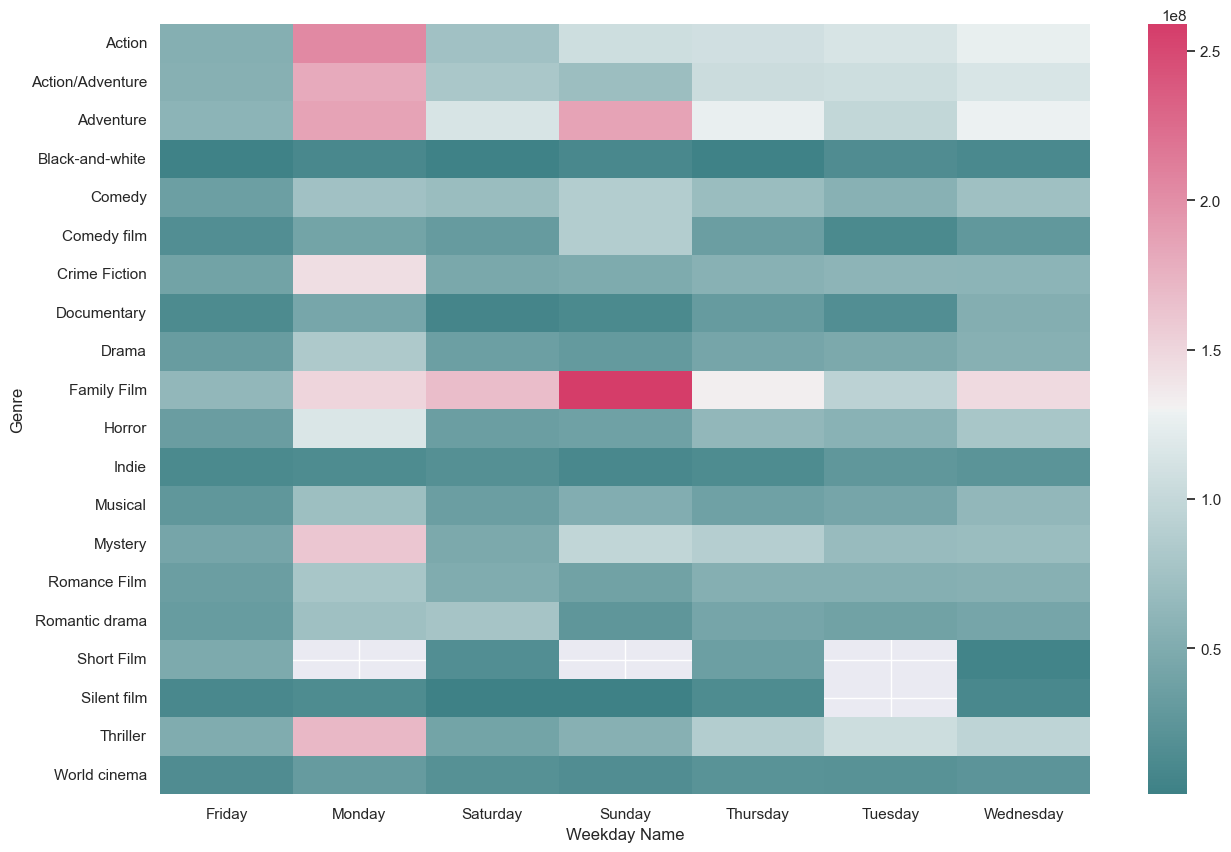

In [39]:
df_movie_genre_boxoffice = df_movie_genre.copy(deep=True)
df_movie_genre_boxoffice.dropna(subset=['Box office'], inplace=True)

df_genre_boxoffice = pd.crosstab(df_movie_genre_boxoffice['Genre'],df_movie_genre_boxoffice['Weekday Name'],
                  values=df_movie_genre_boxoffice['Box office'],aggfunc='mean')

plt.subplots(figsize=(15, 10))
sbn.heatmap(df_genre_boxoffice, annot=False, cmap=sbn.diverging_palette(200, 0, as_cmap=True))
plt.show()